In [90]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [119]:
# PARAMETROS
ruta = os.path.join("..", "data", "raw")
ruta_processed = os.path.join("..", "data", "processed")
date_train = ['2014-06-30', '2014-07-31']
date_test = '2014-08-31'

In [76]:
# OBJETOS 
df_dict = {}

In [77]:
for dirname, _, filenames in os.walk(ruta):
    for filename in filenames:
        if filename.endswith(".csv"):
            filepath = os.path.join(dirname, filename)
            df = pd.read_csv(filepath)
            key = os.path.splitext(filename)[0]
            df_dict[key] = df

# Verifica los nombres de los DataFrames guardados
print(df_dict.keys())

dict_keys(['dataset_prueba', 'data_dict'])


Exploración de Datos

In [78]:
df_dict['dataset_prueba'].head(2)

,last_date_of_month,arpu,onnet_mou,offnet_mou,roam_ic_mou,roam_og_mou,loc_og_t2t_mou,loc_og_t2m_mou,loc_og_t2f_mou,loc_og_t2c_mou,...,arpu_3g,arpu_2g,night_pck_user,monthly_2g,sachet_2g,monthly_3g,sachet_3g,fb_user,churn,mobile_number
0,8/31/2014,213.803,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,...,212.17,212.17,0.0,0,0,1,0,1.0,0,7000842753
1,8/31/2014,268.321,7.68,304.76,0.0,0.0,7.68,291.86,0.0,0.0,...,0.00,7.60,0.0,0,2,0,0,1.0,0,7001865778


In [79]:
df_dict['dataset_prueba'].columns

Index(['last_date_of_month', 'arpu', 'onnet_mou', 'offnet_mou', 'roam_ic_mou',
       'roam_og_mou', 'loc_og_t2t_mou', 'loc_og_t2m_mou', 'loc_og_t2f_mou',
       'loc_og_t2c_mou', 'loc_og_mou', 'std_og_t2t_mou', 'std_og_t2m_mou',
       'std_og_t2f_mou', 'std_og_t2c_mou', 'std_og_mou', 'isd_og_mou',
       'spl_og_mou', 'og_others', 'total_og_mou', 'loc_ic_t2t_mou',
       'loc_ic_t2m_mou', 'loc_ic_t2f_mou', 'loc_ic_mou', 'std_ic_t2t_mou',
       'std_ic_t2m_mou', 'std_ic_t2f_mou', 'std_ic_t2o_mou', 'std_ic_mou',
       'total_ic_mou', 'spl_ic_mou', 'isd_ic_mou', 'ic_others',
       'total_rech_num', 'total_rech_amt', 'max_rech_amt', 'date_of_last_rech',
       'last_day_rch_amt', 'date_of_last_rech_data', 'total_rech_data',
       'max_rech_data', 'count_rech_2g', 'count_rech_3g', 'av_rech_amt_data',
       'vol_2g_mb', 'vol_3g_mb', 'arpu_3g', 'arpu_2g', 'night_pck_user',
       'monthly_2g', 'sachet_2g', 'monthly_3g', 'sachet_3g', 'fb_user',
       'churn', 'mobile_number'],
      dt

In [80]:
df_dict['dataset_prueba']['total_rech_num'].values

array([ 2, 11,  2, ...,  5,  3,  5], shape=(299997,))

Analisis de Datos

In [81]:
df_dict['dataset_prueba']['last_date_of_month'] = pd.to_datetime(df_dict['dataset_prueba']['last_date_of_month'])

In [82]:
df_train = df_dict['dataset_prueba'][df_dict['dataset_prueba']['last_date_of_month'].isin(pd.to_datetime(date_train))].copy()
df_test = df_dict['dataset_prueba'][df_dict['dataset_prueba']['last_date_of_month'] == pd.to_datetime(date_test)].copy()

1. Clasificación de clientes a partir de la variable ARPU

In [83]:
def clasificacion_clientes(df, Variable="arpu", cortes={0.9: 'platino', 0.8: 'gold'}):
    cortes_ordenados = sorted(cortes.items(), reverse=True)

    clasificacion = pd.Series('normal', index=df.index)
    flag_clasificacion = pd.Series(False, index=df.index)
    
    for p, categoria in cortes_ordenados:
        valor_corte = df[Variable].quantile(p)
        faltante = (df[Variable] >= valor_corte) & (~flag_clasificacion)
        clasificacion[faltante] = categoria
        flag_clasificacion[faltante] = True

    return clasificacion

In [84]:
cortes = {0.9: 'platino', 0.8: 'gold'}
df_train['clasificacion_clientes_revenue'] = clasificacion_clientes(df_train, cortes=cortes)

print(df_train['clasificacion_clientes_revenue'].value_counts())

clasificacion_clientes_revenue
normal     159516
gold        19941
platino     19940
Name: count, dtype: int64


2. Generación de la variable flag_recarga

In [85]:
def crea_flag_binario(df, variable = 'total_rech_num', nueva_columna = 'rech'):
    df[nueva_columna] = (df[variable] > 0).astype(int)
    return df

In [86]:
df_train = crea_flag_binario(df_train)
print(df_train['rech'].value_counts())

rech
1    196624
0      2773
Name: count, dtype: int64


3. la proporción de churn de cada mes (junio y julio) 

In [87]:
def eliminar_nulos_proporcion(df, proporcion_nulos=0.7):
    nan_columnas = df.isnull().mean()
    columnas_eliminadas = nan_columnas[nan_columnas > proporcion_nulos].index.tolist()
    df_clean = df.drop(columns=columnas_eliminadas)
    return df_clean, columnas_eliminadas

In [88]:
print(f"Número de columnas antes de eliminar: {df_train.shape[1]}")
df_train, cols_borradas = eliminar_nulos_proporcion(df_train, proporcion_nulos=0.7)
print(f"Número de columnas borradas: {len(cols_borradas)}")
print(f"Número de columnas restantes: {df_train.shape[1]}")

Número de columnas antes de eliminar: 58
Número de columnas borradas: 10
Número de columnas restantes: 48


4. Proporcion de Churn por detalle

In [113]:
def proporcion_target_por_periodo(df, target='churn', periodo='last_date_of_month', periodos=None, decimales=3):       
    if not pd.api.types.is_datetime64_any_dtype(df[periodo]):
        df = df.copy()

    if periodos is not None:
        periodos_dt = pd.to_datetime(periodos)
        data = df[df[periodo].isin(periodos_dt)]
    else:
        data = df
        
    resultado = (
        data.groupby(periodo)[target]
        .mean()
        .round(decimales)
        .reset_index(name=f'prop_{target}')
    )
    for _, row in resultado.iterrows():
        print(f"Churn {row[periodo].date()}: {row[f'prop_{target}']}")
    return resultado

In [114]:
proporcion_target_por_periodo( df_train, target='churn', periodo='last_date_of_month', periodos=['2014-06-30', '2014-07-31'])

Churn 2014-06-30: 0.01
Churn 2014-07-31: 0.015


,last_date_of_month,prop_churn
0,2014-06-30,0.010
1,2014-07-31,0.015


5. ¿Se observan diferencias en la distribución de la variable total_rech_num? 

In [ ]:
def plot_distribucion_segmentada(df, variable, grupo, bins=30, titulo=None):
    plt.figure(figsize=(10, 5))
    sns.histplot( data=df, x=variable, hue=grupo, bins=bins, element='step', 
        stat='density', common_norm=False )
    plt.title(titulo if titulo else f'Distribución de {variable} por {grupo}')
    plt.show()

In [ ]:
def plot_distribucion_por_mes(df, variable, grupo, fecha_col, bins=30, titulo=None):
    g = sns.FacetGrid(df, col=fecha_col, height=4, aspect=1.5, sharex=True, sharey=True)
    g.map_dataframe(
        sns.histplot,
        x=variable,
        hue=grupo,
        bins=bins,
        element='step',
        stat='density',
        common_norm=False
    )
    g.add_legend()
    g.set_titles(col_template="{col_name}")
    plt.subplots_adjust(top=0.8)
    g.fig.suptitle(titulo if titulo else f"Distribución de {variable} por {grupo} y {fecha_col}")
    plt.show()

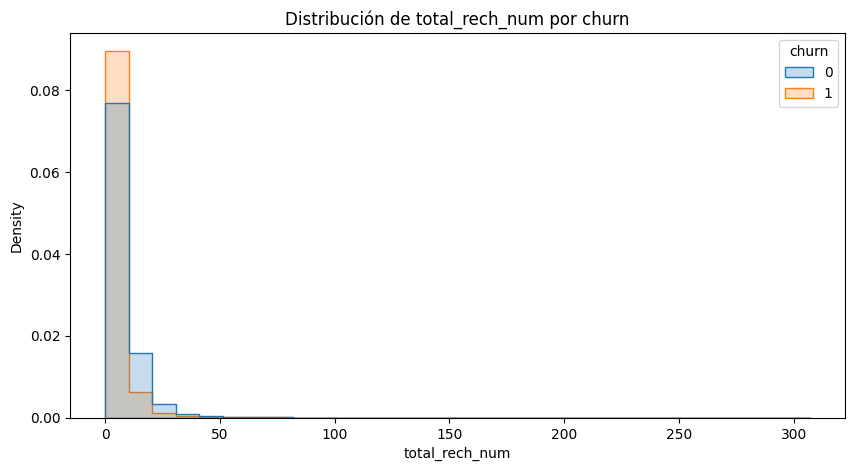

In [ ]:
plot_distribucion_segmentada(
    df_train, variable='total_rech_num',
    grupo='churn', bins=30, titulo='Distribución de total_rech_num por churn' )


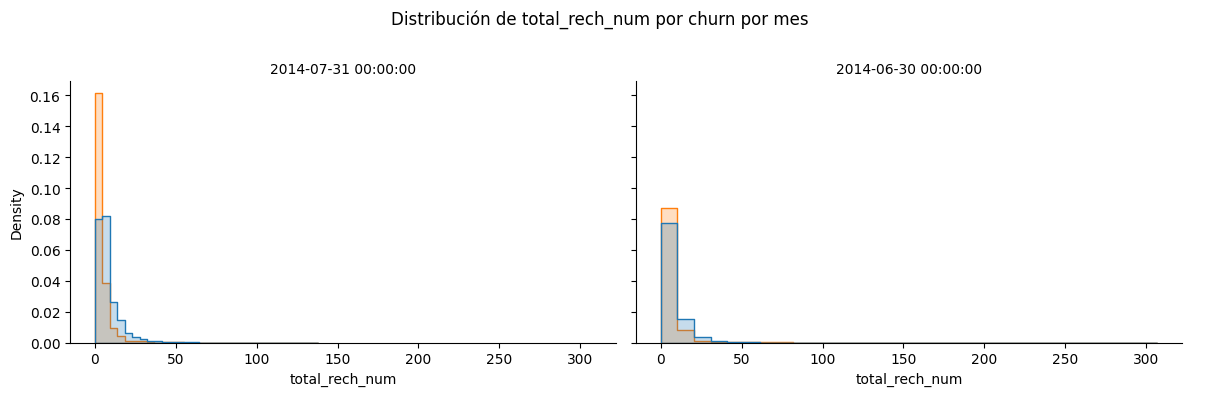

In [105]:
plot_distribucion_por_mes(
    df_train, variable='total_rech_num',
    grupo='churn', fecha_col='last_date_of_month',
    bins=30, titulo='Distribución de total_rech_num por churn por mes'
)

In [ ]:
print(df_train.groupby('churn')['total_rech_num'].describe())

          count      mean       std  min  25%  50%   75%    max
churn                                                          
0      196846.0  7.698323  7.078632  0.0  3.0  6.0  10.0  307.0
1        2551.0  4.123089  5.589674  0.0  1.0  3.0   5.0   80.0


Sí. Los clientes que hicieron churn suelen tener menos recargas permanecen.
Esto sugiere que una baja actividad de recargas podría ser un indicador de probabilidad de fuga.

In [117]:
df_test = crea_flag_binario(df_test)
df_test['clasificacion_clientes_revenue'] = clasificacion_clientes(df_test, cortes=cortes)

In [118]:
df_test = df_test[df_train.columns]

In [120]:
df_train.to_csv(os.path.join(ruta_processed, "df_train.csv"), index=False)
df_test.to_csv(os.path.join(ruta_processed, "df_test.csv"), index=False)